In [1]:
from pathlib import Path
import load_data as ld
from piecewise import *
import pickle

In [2]:
## Define the paths for the data from EPOGH cohort
parent_folder = os.path.join(*Path(os.getcwd()).parts[:-2], "LV Strain Curves")
data_path = os.path.join(parent_folder, "Data/EPOGH/Strain curves (Filtered)")
save_data_path = os.path.join(parent_folder, "Results/Summary Index/GMM/EPOGH/")

#create save_data_path directory if not exist
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

avc_files = ["Data/EPOGH/EPOGH_AVC.xlsx"]

C:\Users\vagge\Desktop\PhD\Deformation Curves\LV Strain Curves


In [11]:
## Load the data from EPOGH cohort and execute temporal alignment algorithm
original_data, data, patient_id, interval = ld.read_data(data_path)
excluded_patients1, avc_times = ld.read_avc_time(parent_folder, avc_files)
excluded_patients2 = []
p_wave_times = pd.DataFrame(columns=["ID", "PQ Interval", "P duration (ms)"])

original_data, data, patient_id, interval = exclude_patients(excluded_patients1, excluded_patients2, original_data, data, patient_id, interval)
decision = "peak"
reference_patient_id = "110101"
_, deformation, _, _, reference_time = get_aligned_signals(original_data, decision, interval, patient_id, reference_patient_id, avc_times, p_wave_times)

deformation = np.array(deformation)
patient_id = np.array(patient_id)

C:\Users\vagge\Desktop\PhD\Deformation Curves\Codes\summary_indexes\load_data.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_excel(f, usecols=(0, 1)), ignore_index=True)


Start slicing data
Start Alignment


In [13]:
## Extract the features from the time series strain curves
extracted_features = extract_time_series_features(reference_time, deformation, patient_id, save_data_path, do_plot=False)

training_data = {"peak": extracted_features["Peak"],
                 "peak_slopes": extracted_features[["Systolic Slope", "Diastolic Slope","Peak"]],
                 "all":extracted_features}

100%|██████████| 545/545 [05:39<00:00,  1.60it/s]


In [14]:
select_features = "all"
save_data_path = os.path.join(save_data_path, select_features)
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

In [16]:
## Perform clustering with already trained model
clustering_model = pickle.load(open("gmm_model.pkl", "rb"))
clusters = clustering_model.predict(training_data[select_features])
representative_centers = np.array(produce_centroids(clusters, deformation))

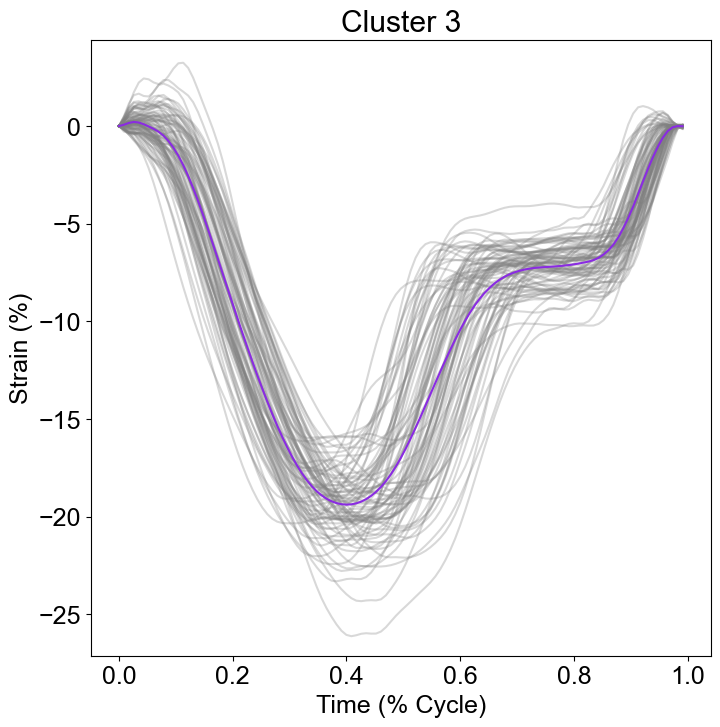

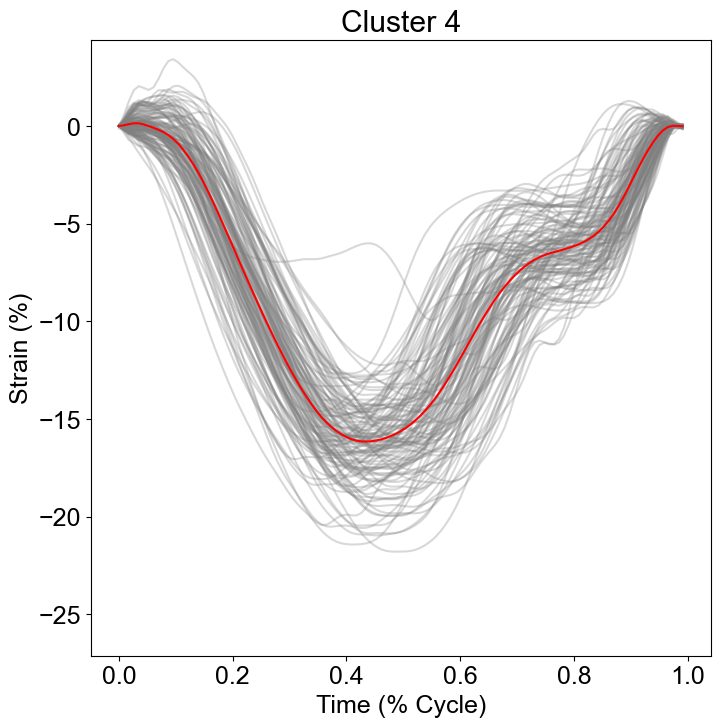

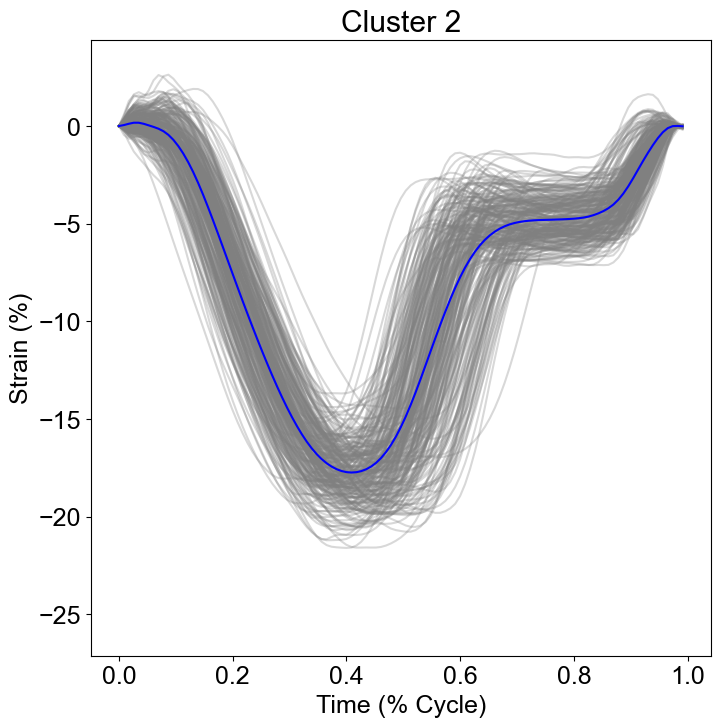

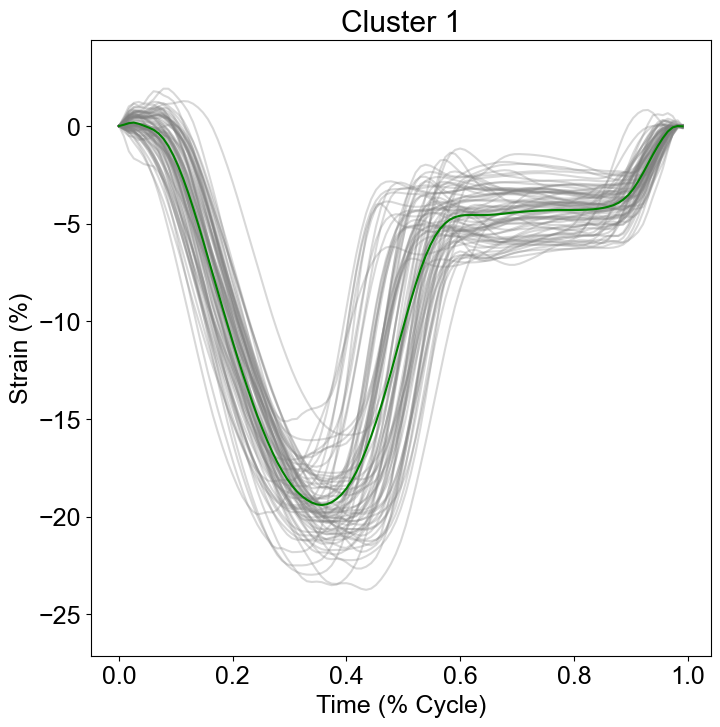

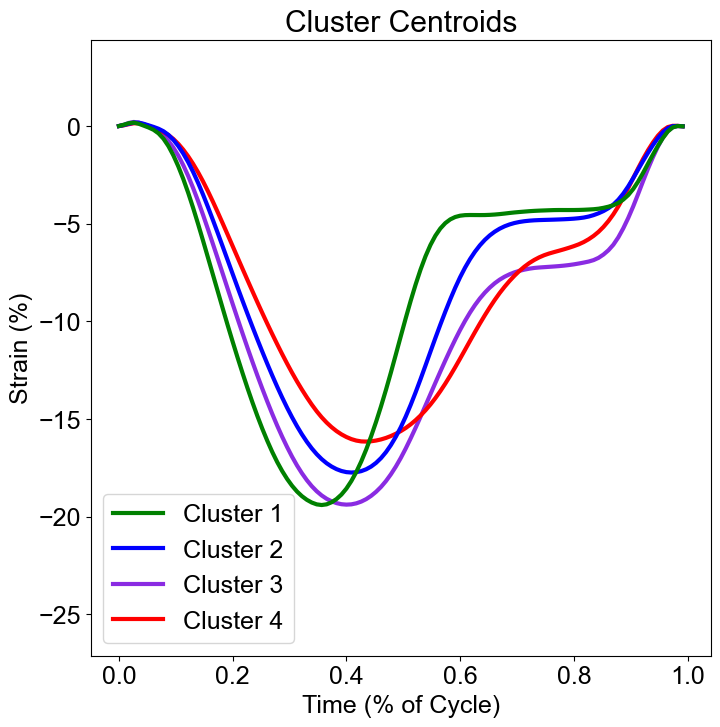

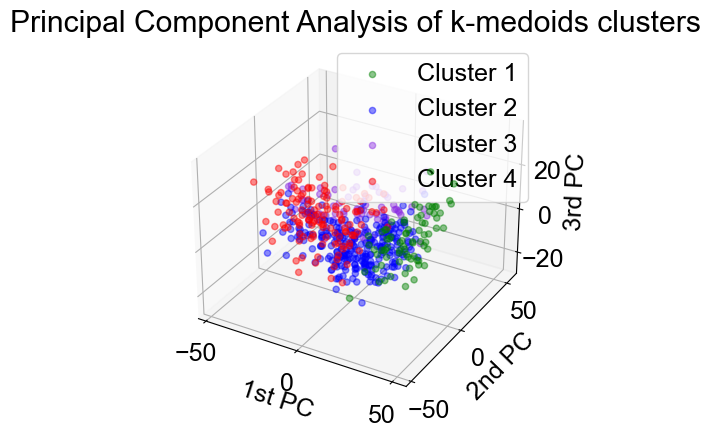

C:\Users\vagge\Desktop\PhD\Deformation Curves\Codes\summary_indexes\utils.py:150: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\vagge\Desktop\PhD\Deformation Curves\Codes\summary_indexes\utils.py:159: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [18]:
## Visualize the clustering results
cluster_labels = {0:3, 1:4, 2:2, 3:1}
cluster_colours = {0:"blueviolet", 1:"red", 2:"blue", 3:"green", 4:"blueviolet"}
patient_id = patient_id.tolist()
# groups the patients' ids per cluster. Returns a list
clustered_id = analyze_patient(clusters, patient_id)

# writes an excel file with the patient's ID and its assigned cluster label
write2excel(clusters, patient_id, save_data_path, cluster_labels)

# plots the strain traces grouped per cluster with Matplotlib and plotly. Matplotlib produces png and svg files.
visualize_clustering_results(reference_time, deformation, clustered_id, clusters, patient_id, representative_centers,
                             save_data_path, cluster_labels=cluster_labels, cluster_colours=cluster_colours)

# plot the first three principal components of the strain curves
plot_pca(clusters, deformation, patient_id, save_data_path, cluster_labels=cluster_labels,
         cluster_colours=cluster_colours)

# plots the gradient of the Strain traces with Matplotlib and plotly.
plot_gradients(deformation, reference_time, clusters, clustered_id,patient_id, save_data_path,
               cluster_labels=cluster_labels, cluster_colours=cluster_colours)